# Кластеризация и метрики качества

In [1]:
import numpy as np

In [2]:
from  matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

### Данные

В sklearn.datasets есть разные наборы данных, можно выбрать другие 

In [38]:
from sklearn.datasets import make_moons, make_blobs

In [4]:
X, y = make_moons(n_samples=200, noise=.05, random_state=0)

In [56]:
X, y = make_blobs(n_samples=200, centers=2, cluster_std=2.5, random_state=0)

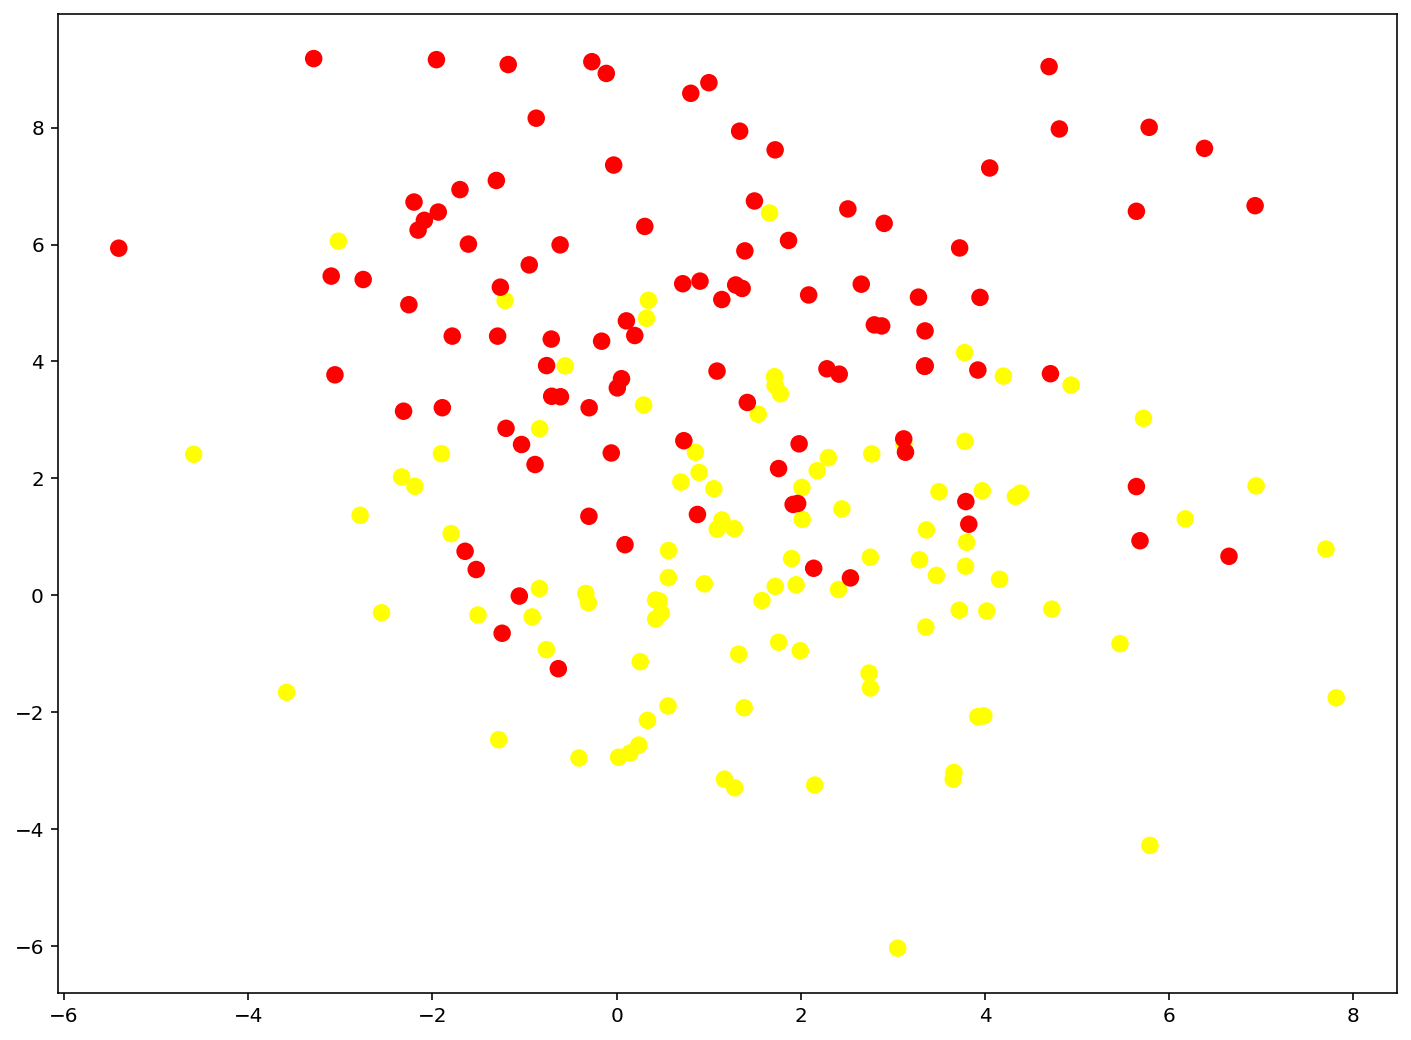

In [57]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=60)

приведем данные по обеим осям к нормальному распределению

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()

In [60]:
X_scaled = scaler.fit_transform(X)

Форма осталась, но диапазоны выровнялись

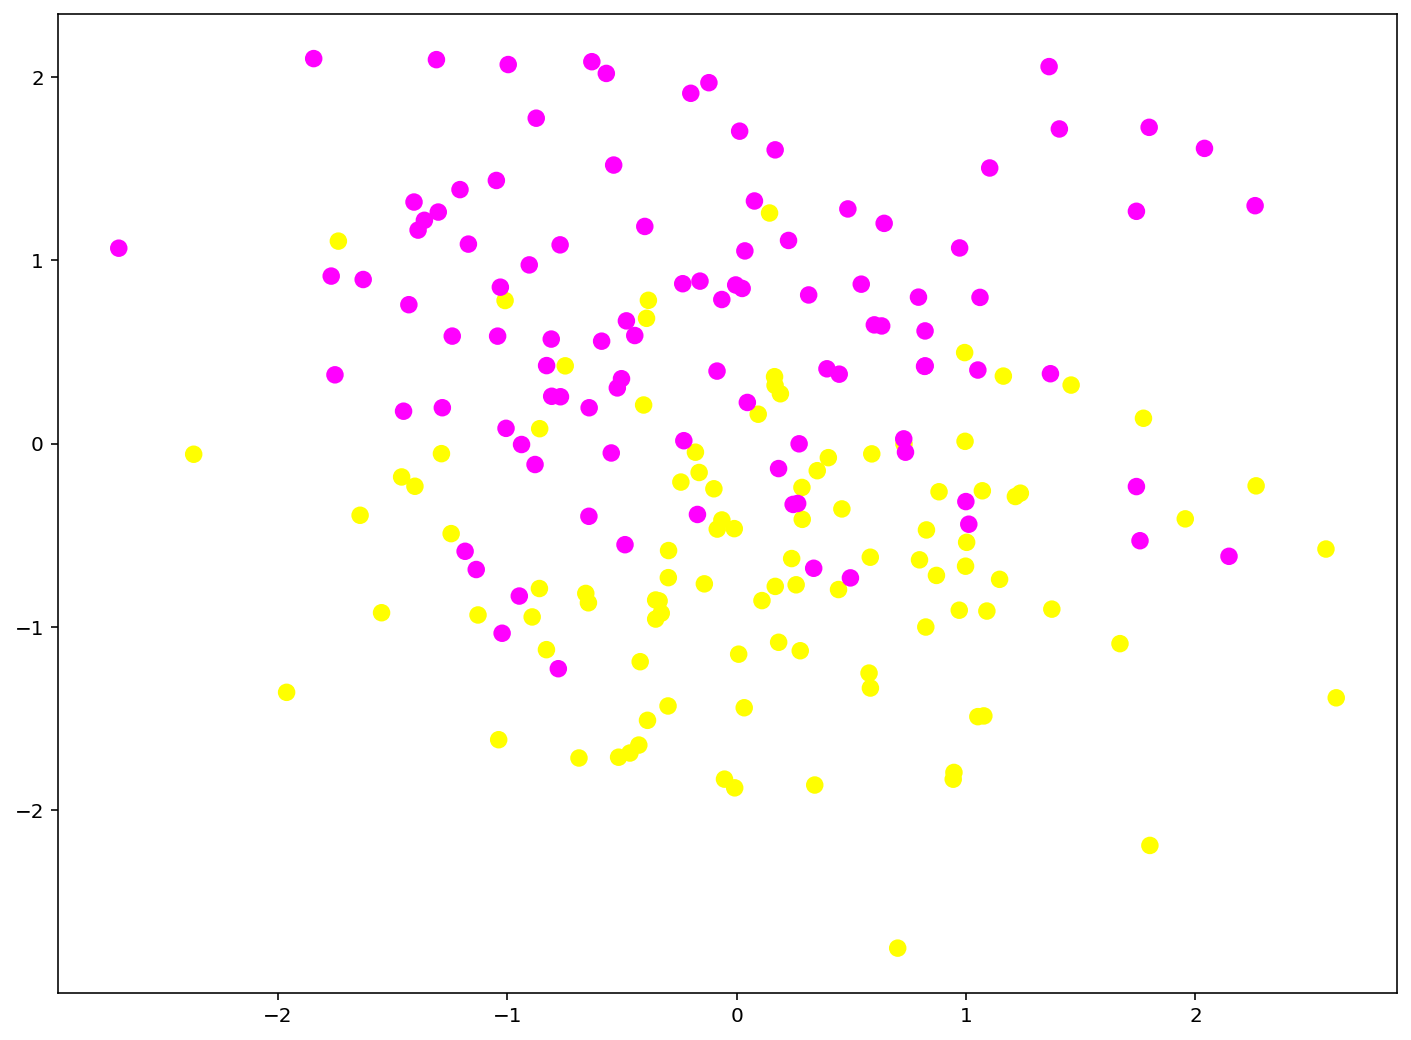

In [61]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='spring', s=60)

### Кластеризация

теперь кластеризуем с помощью различных методов

In [62]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [63]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=2),
    AgglomerativeClustering(n_clusters=2),
    DBSCAN(),
]

сделаем случайное предсказание

In [64]:
clusters_random = np.random.randint(low=0, high=2, size=len(X))

и функцию-заготовку, которая считает 2 метрики качества и генерирует заголовки для графиков

In [65]:
def get_descr(algo_name, y, y_pred, X):
    return '{}\nARI {:.2f}\nSilhouette {:.2f}'.format(
        algo_name,
        adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

In [66]:
import warnings
warnings.filterwarnings('ignore')

проследите за ростом API и за падением Silhouette (хотя этот показатель по своему значению тоже должен расти)

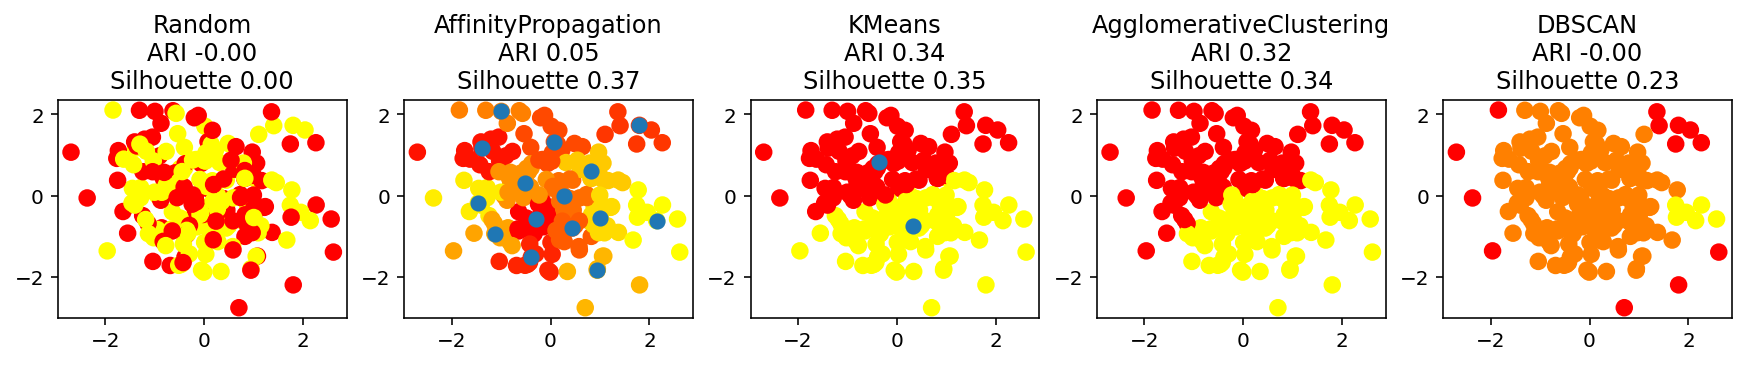

In [67]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_random, cmap='autumn', s=60) #alpha=.2) # прозрачность точек alpha=1 точки не прозрачны 
axes[0].set_title(get_descr('Random', y, clusters_random, X_scaled))
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in ('KMeans', 'AffinityPropagation'):
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

## Подбор количества класстеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [68]:
k_inertia = []
ks = range(1, 11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

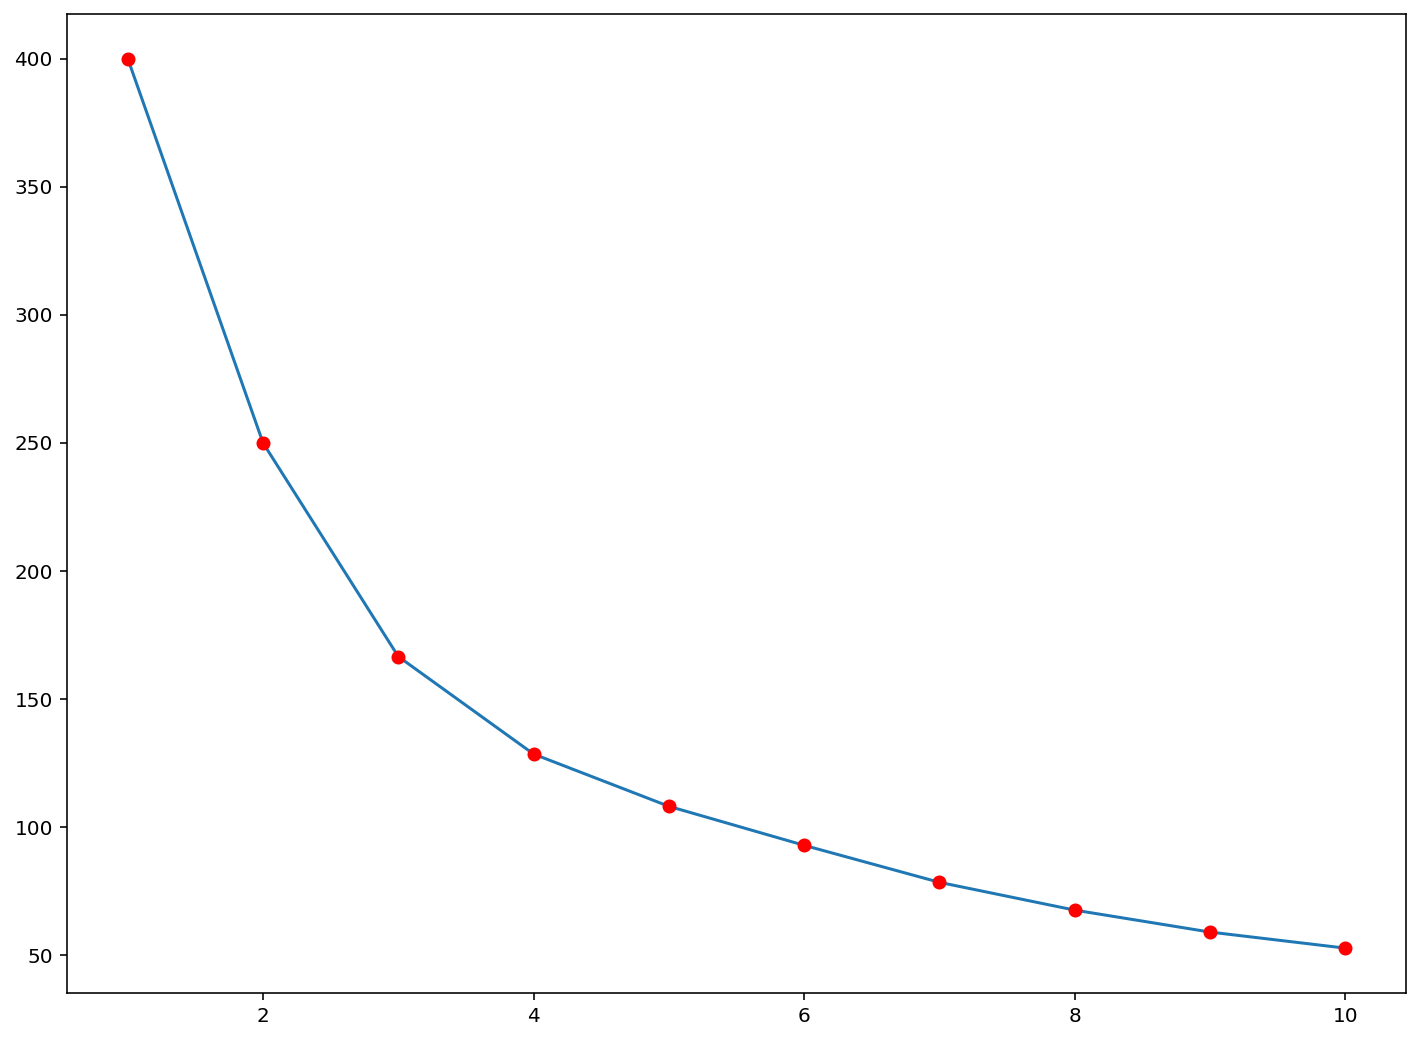

In [71]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia, 'ro')

Как подобрать оптимальные значения? Будем на каждом шаге смотреть изменения inertia, и в тот момент, когда оно
резко замедлится (относительно предыдущег значения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

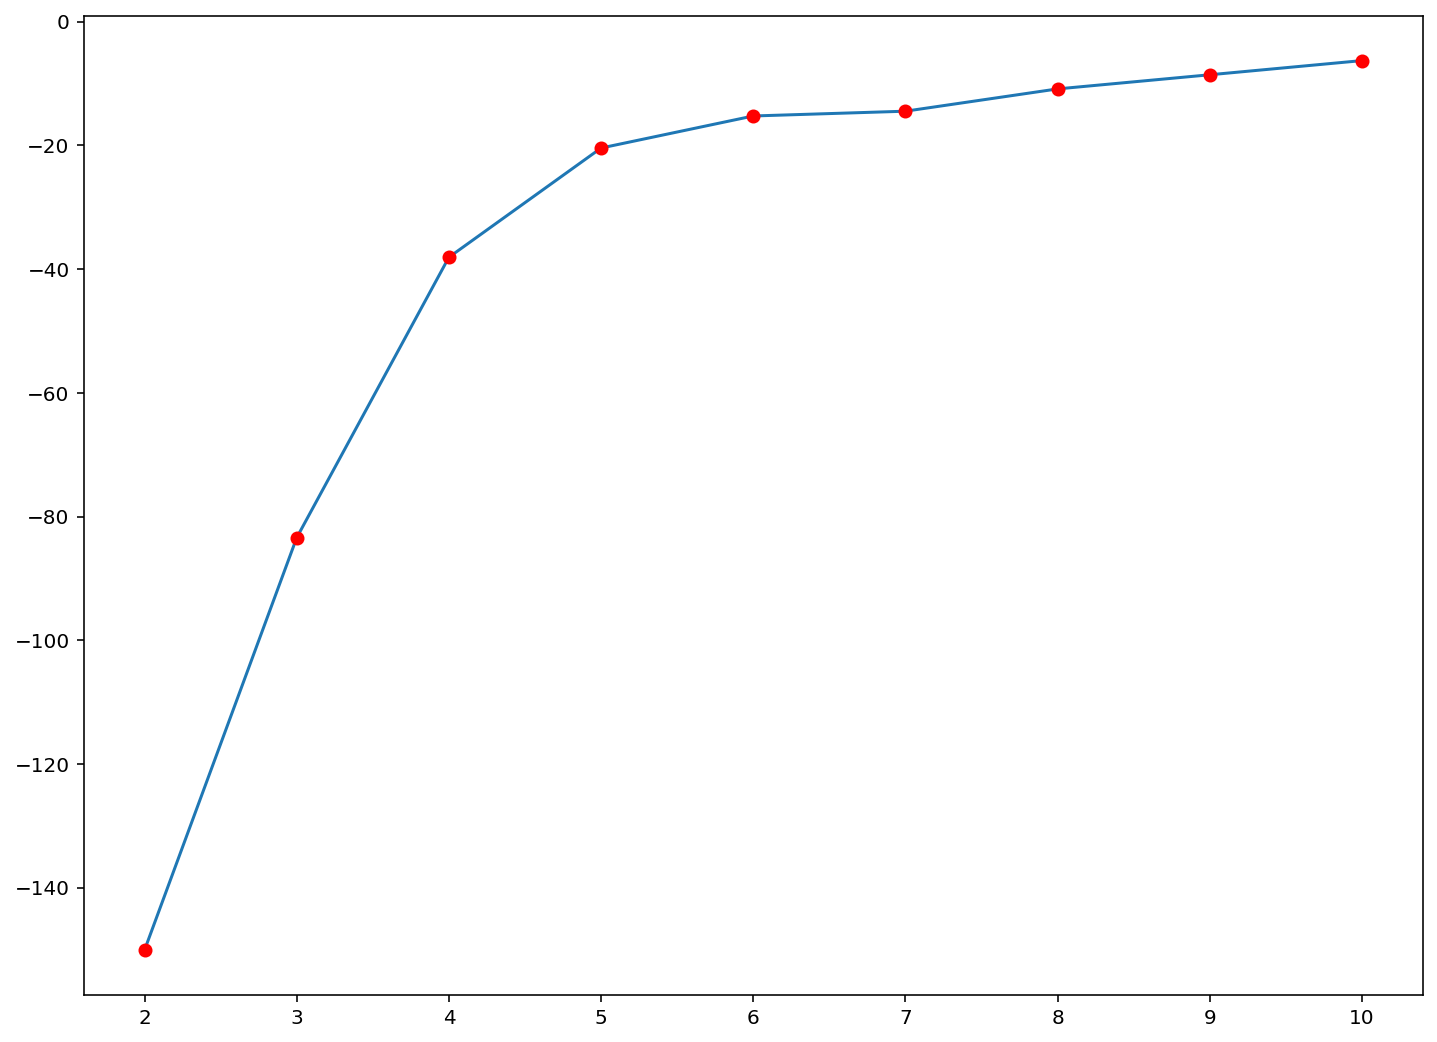

In [73]:
diff = np.diff(k_inertia)

plt.plot(ks[1:], diff)
plt.plot(ks[1:], diff, 'ro')

Теперь можно найти оптимальное ччсло кластеров по этой формуле

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [77]:
print('*****', diff[1:])
print('+++++', diff[:-1])

***** [-83.41511459 -38.0735159  -20.41138493 -15.22831225 -14.45515346
 -10.85045544  -8.5656888   -6.27474231]
+++++ [-150.08886645  -83.41511459  -38.0735159   -20.41138493  -15.22831225
  -14.45515346  -10.85045544   -8.5656888 ]


In [74]:
diff_r = diff[1:] / diff[:-1]

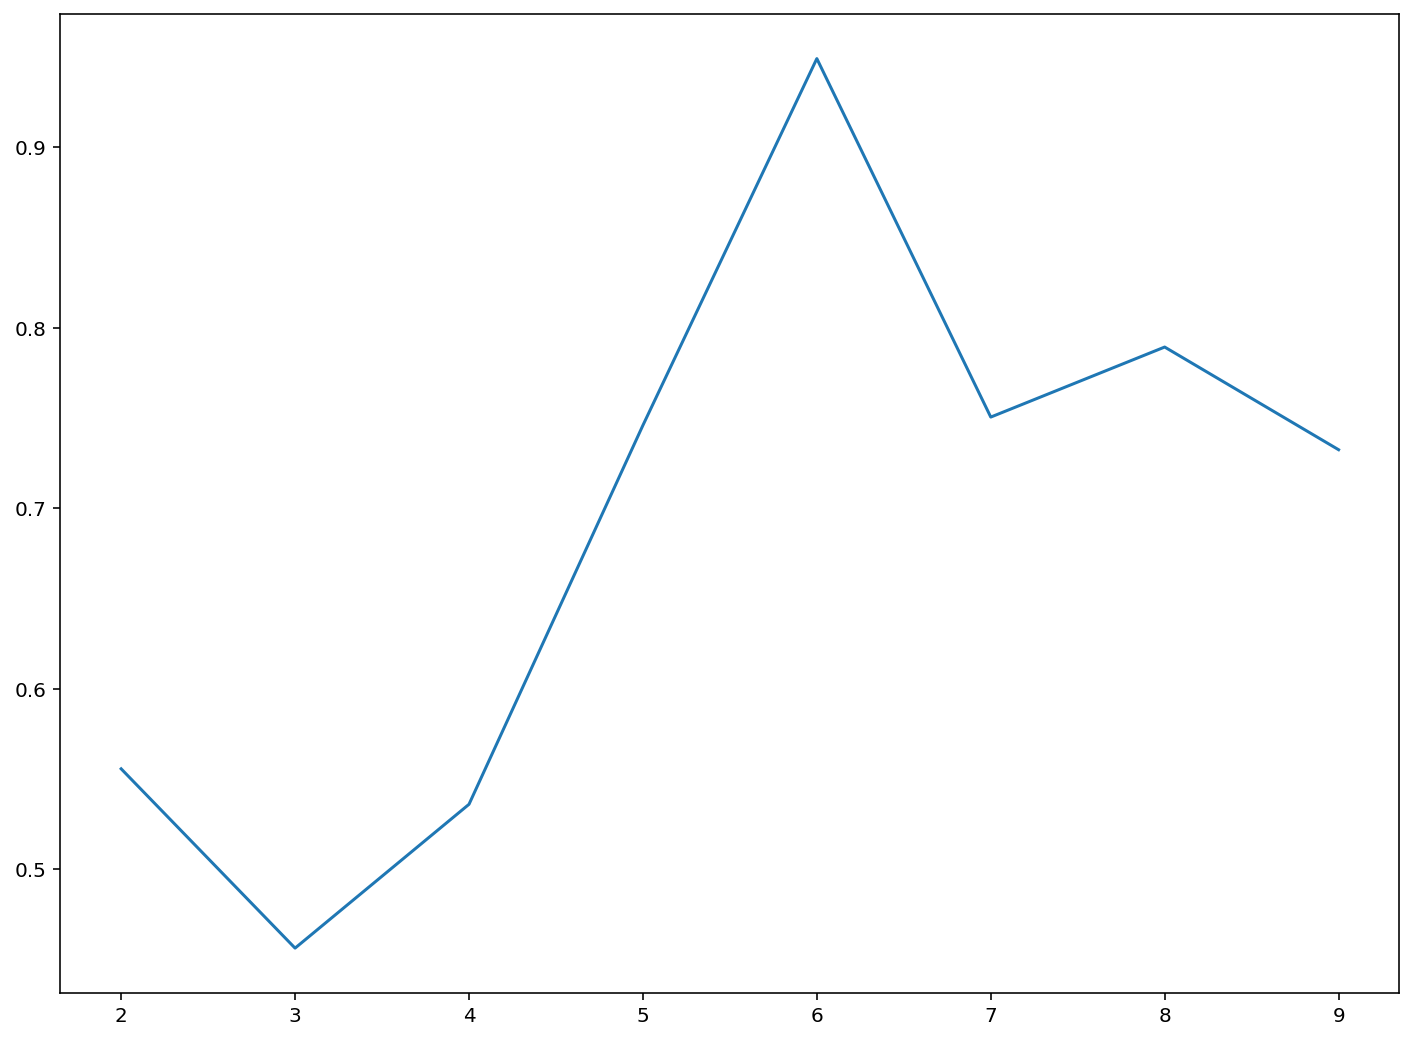

In [75]:
plt.plot(ks[1: -1], diff_r)

In [79]:
k_opt = ks[np.argmin(diff_r) + 1]
k_opt

3

Эта эвристика совсем не гарантирует наилучшее разбиение